<a href="https://colab.research.google.com/github/yghebre6/Swift-for-TensorFlow/blob/main/Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Xception in S4TF

## Configure imports

In [ ]:
%install '.package(url: "https://github.com/tensorflow/swift-models", .branch("tensorflow-0.11"))' Datasets
print("\u{001B}[2J")

In [ ]:
import Datasets
import ImageClassificationModels
import TensorFlow
import Python
import Foundation

In [ ]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

let plt = Python.import("matplotlib.pyplot")
let np  = Python.import("numpy")
let path = Python.import("os.path")

## Model

### Conv + BatchNorm layer

In [ ]:
public struct ConvBlock: Layer {
    var conv: Conv2D<Float>
    var batch_norm: BatchNorm<Float>
    @noDerivative var useRelu: Bool

    public init(kernelSize: Int, inputChannels: Int, ouputChannels: Int, strides: Int, padding: Padding = .same, useRelu: Bool) {
      self.conv = Conv2D(filterShape: (kernelSize, kernelSize, inputChannels, ouputChannels),
                    strides: (strides, strides),
                    padding: padding,
                    useBias: false)
      self.batch_norm = BatchNorm(axis: -1,
                        momentum: 0.99,
                        offset: Tensor(zeros: [ouputChannels]),
                        scale: Tensor(ones: [ouputChannels]),
                        epsilon: 0.001,
                        runningMean: Tensor(zeros: [ouputChannels]),
                        runningVariance: Tensor(ones: [ouputChannels]))
      self.useRelu = useRelu
    }
    
    @differentiable
    public func callAsFunction(_ input: Tensor<Float>) -> Tensor<Float> {
        var output = conv(input)
        output = batch_norm(output)
        if (useRelu) {
        output = relu(output)
        }
        return output
    }
}

### Separable Conv block

In [ ]:
public struct SeparableConvBlock: Layer {
    var separable_conv1: SeparableConv2D<Float>
    var batch_norm1: BatchNorm<Float>
    var separable_conv2: SeparableConv2D<Float>
    var batch_norm2: BatchNorm<Float>
    var max_pool: MaxPool2D<Float>
    var glob_avg_pool = GlobalAvgPool2D<Float>()
    @noDerivative var reluFirst: Bool
    @noDerivative var useMaxPool: Bool

    public init(kernelSize: Int, inputChannels: Int, ouputChannels1: Int, ouputChannels2: Int, strides: Int, reluFirst: Bool = false, useMaxPool: Bool) {
      self.separable_conv1 = SeparableConv2D(depthwiseFilterShape: (kernelSize, kernelSize, inputChannels, 1),
                              pointwiseFilterShape: (1, 1, inputChannels, ouputChannels1),
                              strides: (strides, strides),
                              padding: .same,
                              useBias: false)
      self.batch_norm1 = BatchNorm(axis: -1,
                        momentum: 0.99,
                        offset: Tensor(zeros: [ouputChannels1]),
                        scale: Tensor(ones: [ouputChannels1]),
                        epsilon: 0.001,
                        runningMean: Tensor(zeros: [ouputChannels1]),
                        runningVariance: Tensor(ones: [ouputChannels1]))
      self.separable_conv2 = SeparableConv2D(depthwiseFilterShape: (kernelSize, kernelSize, ouputChannels1, 1),
                              pointwiseFilterShape: (1, 1, ouputChannels1, ouputChannels2),
                              strides: (strides, strides),
                              padding: .same,
                              useBias: false)
      self.batch_norm2 = BatchNorm(axis: -1,
                        momentum: 0.99,
                        offset: Tensor(zeros: [ouputChannels2]),
                        scale: Tensor(ones: [ouputChannels2]),
                        epsilon: 0.001,
                        runningMean: Tensor(zeros: [ouputChannels2]),
                        runningVariance: Tensor(ones: [ouputChannels2]))
      self.max_pool = MaxPool2D(poolSize: (3, 3), strides: (2, 2), padding: .same)
      self.reluFirst = reluFirst
      self.useMaxPool = useMaxPool
    }
    
    @differentiable
    public func callAsFunction(_ input: Tensor<Float>) -> Tensor<Float> {
        var output = input
        if reluFirst {
          output = relu(output)
        }
        output = separable_conv1(output)
        output = batch_norm1(output)
        output = relu(output)
        output = separable_conv2(output)
        output = batch_norm2(output)
        if useMaxPool {
          output =  max_pool(output)
        } else {
          output = relu(output)
          output = glob_avg_pool(output)
        }
        return output
    }
}

### Xception

Architecture as described here https://arxiv.org/pdf/1610.02357.pdf

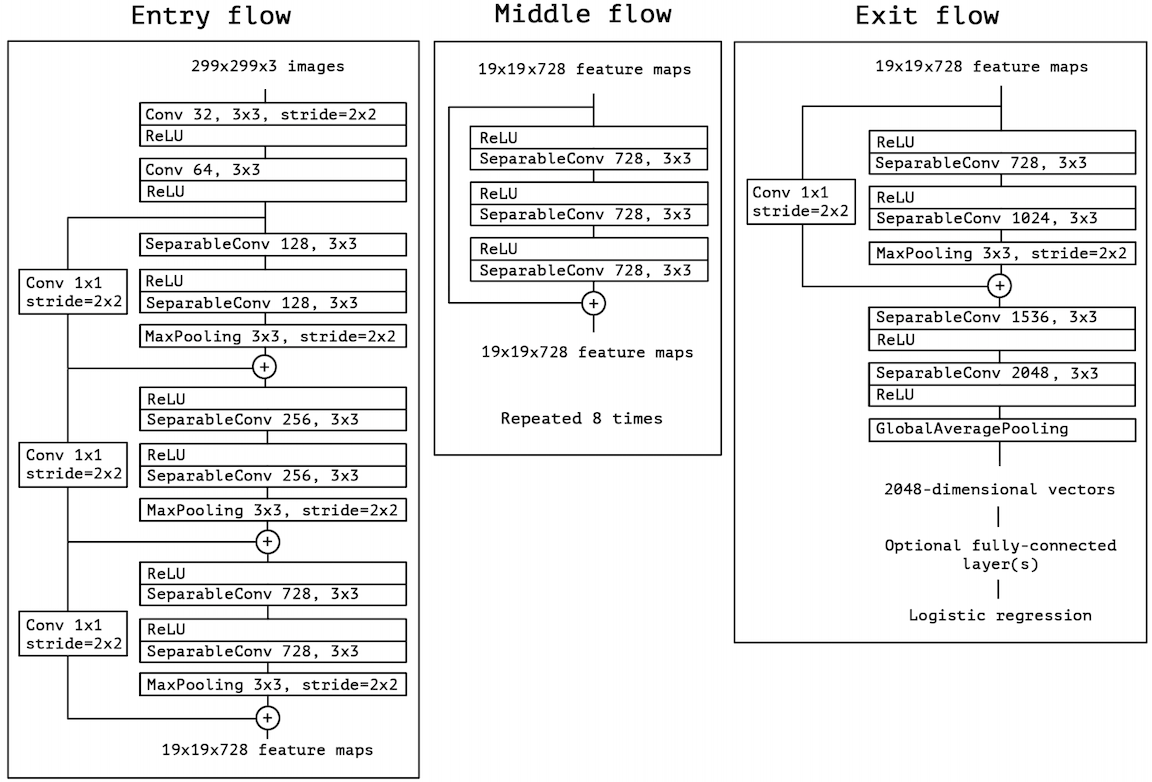



In [ ]:
public struct Xception: Layer {
    // Entry Flow
    var entry_conv_block1 = ConvBlock(kernelSize: 3, inputChannels: 3, ouputChannels: 32, strides: 2, padding: .valid, useRelu: true)
    var entry_conv_block2 = ConvBlock(kernelSize: 3, inputChannels: 32, ouputChannels: 64, strides: 1, padding: .valid, useRelu: true)
    var entry_residual1 = ConvBlock(kernelSize: 1, inputChannels: 64, ouputChannels: 128, strides: 2, useRelu: false)
    var entry_separable_conv_block1 = SeparableConvBlock(kernelSize: 3, inputChannels: 64, ouputChannels1: 128, ouputChannels2: 128, strides: 1, useMaxPool: true)
    var entry_separable_conv_block2 = SeparableConvBlock(kernelSize: 3, inputChannels: 128, ouputChannels1: 256, ouputChannels2: 256, strides: 1, reluFirst: true, useMaxPool: true)
    var entry_residual2 = ConvBlock(kernelSize: 1, inputChannels: 128, ouputChannels: 256, strides: 2, useRelu: false)
    var entry_separable_conv_block3 = SeparableConvBlock(kernelSize: 3, inputChannels: 256, ouputChannels1: 728, ouputChannels2: 728, strides: 1, reluFirst: true, useMaxPool: true)
    var entry_residual3 = ConvBlock(kernelSize: 1, inputChannels: 256, ouputChannels: 728, strides: 2, useRelu: false)

    // Middle Flow
    var middle_separable_conv1 = SeparableConv2D<Float>(depthwiseFilterShape: (3, 3, 728, 1),
                              pointwiseFilterShape: (1, 1, 728, 728),
                              strides: (1, 1),
                              padding: .same,
                              useBias: false)
    var middle_batch_norm = BatchNorm<Float>(axis: -1,
                        momentum: 0.99,
                        offset: Tensor(zeros: [728]),
                        scale: Tensor(ones: [728]),
                        epsilon: 0.001,
                        runningMean: Tensor(zeros: [728]),
                        runningVariance: Tensor(ones: [728]))
    var middle_separable_conv2 = SeparableConv2D<Float>(depthwiseFilterShape: (3, 3, 728, 1),
                          pointwiseFilterShape: (1, 1, 728, 728),
                          strides: (1, 1),
                          padding: .same,
                          useBias: false)
    var middle_separable_conv3 = SeparableConv2D<Float>(depthwiseFilterShape: (3, 3, 728, 1),
                              pointwiseFilterShape: (1, 1, 728, 728),
                              strides: (1, 1),
                              padding: .same,
                              useBias: false)
    var middle_separable_conv4 = SeparableConv2D<Float>(depthwiseFilterShape: (3, 3, 728, 1),
                              pointwiseFilterShape: (1, 1, 728, 728),
                              strides: (1, 1),
                              padding: .same,
                              useBias: false)
    var middle_separable_conv5 = SeparableConv2D<Float>(depthwiseFilterShape: (3, 3, 728, 1),
                              pointwiseFilterShape: (1, 1, 728, 728),
                              strides: (1, 1),
                              padding: .same,
                              useBias: false)
    var middle_separable_conv6 = SeparableConv2D<Float>(depthwiseFilterShape: (3, 3, 728, 1),
                              pointwiseFilterShape: (1, 1, 728, 728),
                              strides: (1, 1),
                              padding: .same,
                              useBias: false)
    var middle_separable_conv7 = SeparableConv2D<Float>(depthwiseFilterShape: (3, 3, 728, 1),
                              pointwiseFilterShape: (1, 1, 728, 728),
                              strides: (1, 1),
                              padding: .same,
                              useBias: false)
    var middle_separable_conv8 = SeparableConv2D<Float>(depthwiseFilterShape: (3, 3, 728, 1),
                              pointwiseFilterShape: (1, 1, 728, 728),
                              strides: (1, 1),
                              padding: .same,
                              useBias: false)
    var middle_separable_conv9 = SeparableConv2D<Float>(depthwiseFilterShape: (3, 3, 728, 1),
                              pointwiseFilterShape: (1, 1, 728, 728),
                              strides: (1, 1),
                              padding: .same,
                              useBias: false)
    var middle_separable_conv10 = SeparableConv2D<Float>(depthwiseFilterShape: (3, 3, 728, 1),
                              pointwiseFilterShape: (1, 1, 728, 728),
                              strides: (1, 1),
                              padding: .same,
                              useBias: false)
    var middle_separable_conv11 = SeparableConv2D<Float>(depthwiseFilterShape: (3, 3, 728, 1),
                              pointwiseFilterShape: (1, 1, 728, 728),
                              strides: (1, 1),
                              padding: .same,
                              useBias: false)
    var middle_separable_conv12 = SeparableConv2D<Float>(depthwiseFilterShape: (3, 3, 728, 1),
                              pointwiseFilterShape: (1, 1, 728, 728),
                              strides: (1, 1),
                              padding: .same,
                              useBias: false)
    var middle_separable_conv13 = SeparableConv2D<Float>(depthwiseFilterShape: (3, 3, 728, 1),
                              pointwiseFilterShape: (1, 1, 728, 728),
                              strides: (1, 1),
                              padding: .same,
                              useBias: false)
    var middle_separable_conv14 = SeparableConv2D<Float>(depthwiseFilterShape: (3, 3, 728, 1),
                              pointwiseFilterShape: (1, 1, 728, 728),
                              strides: (1, 1),
                              padding: .same,
                              useBias: false)
    var middle_separable_conv15 = SeparableConv2D<Float>(depthwiseFilterShape: (3, 3, 728, 1),
                              pointwiseFilterShape: (1, 1, 728, 728),
                              strides: (1, 1),
                              padding: .same,
                              useBias: false)
    var middle_separable_conv16 = SeparableConv2D<Float>(depthwiseFilterShape: (3, 3, 728, 1),
                              pointwiseFilterShape: (1, 1, 728, 728),
                              strides: (1, 1),
                              padding: .same,
                              useBias: false)
    var middle_separable_conv17 = SeparableConv2D<Float>(depthwiseFilterShape: (3, 3, 728, 1),
                              pointwiseFilterShape: (1, 1, 728, 728),
                              strides: (1, 1),
                              padding: .same,
                              useBias: false)
    var middle_separable_conv18 = SeparableConv2D<Float>(depthwiseFilterShape: (3, 3, 728, 1),
                              pointwiseFilterShape: (1, 1, 728, 728),
                              strides: (1, 1),
                              padding: .same,
                              useBias: false)
    var middle_separable_conv19 = SeparableConv2D<Float>(depthwiseFilterShape: (3, 3, 728, 1),
                              pointwiseFilterShape: (1, 1, 728, 728),
                              strides: (1, 1),
                              padding: .same,
                              useBias: false)
    var middle_separable_conv20 = SeparableConv2D<Float>(depthwiseFilterShape: (3, 3, 728, 1),
                              pointwiseFilterShape: (1, 1, 728, 728),
                              strides: (1, 1),
                              padding: .same,
                              useBias: false)
    var middle_separable_conv21 = SeparableConv2D<Float>(depthwiseFilterShape: (3, 3, 728, 1),
                              pointwiseFilterShape: (1, 1, 728, 728),
                              strides: (1, 1),
                              padding: .same,
                              useBias: false)
    var middle_separable_conv22 = SeparableConv2D<Float>(depthwiseFilterShape: (3, 3, 728, 1),
                              pointwiseFilterShape: (1, 1, 728, 728),
                              strides: (1, 1),
                              padding: .same,
                              useBias: false)
    var middle_separable_conv23 = SeparableConv2D<Float>(depthwiseFilterShape: (3, 3, 728, 1),
                              pointwiseFilterShape: (1, 1, 728, 728),
                              strides: (1, 1),
                              padding: .same,
                              useBias: false)
    var middle_separable_conv24 = SeparableConv2D<Float>(depthwiseFilterShape: (3, 3, 728, 1),
                              pointwiseFilterShape: (1, 1, 728, 728),
                              strides: (1, 1),
                              padding: .same,
                              useBias: false)

    // Exit Flow
    var exit_separable_conv_block1 = SeparableConvBlock(kernelSize: 3, inputChannels: 728, ouputChannels1: 728, ouputChannels2: 1024, strides: 1, reluFirst: true, useMaxPool: true)
    var exit_residual = ConvBlock(kernelSize: 1, inputChannels: 728, ouputChannels: 1024, strides: 2, useRelu: false)
    var exit_separable_conv_block2 = SeparableConvBlock(kernelSize: 3, inputChannels: 1024, ouputChannels1: 1536, ouputChannels2: 2048, strides: 1, useMaxPool: false)
    var exit_dropout = Dropout<Float>(probability: 0.6)
    var exit_fc_layer1 = Dense<Float>(inputSize: 2048, outputSize: 4096, activation: relu)
    var exit_fc_layer2 = Dense<Float>(inputSize: 4096, outputSize: 10)

    @differentiable
    public func callAsFunction(_ input: Tensor<Float>) -> Tensor<Float> {
        // Entry Flow
        var output = self.entry_conv_block1(input)
        output = self.entry_conv_block2(output)
        var residual = self.entry_residual1(output)

        output = self.entry_separable_conv_block1(output)
        var sum = residual + output

        output = self.entry_separable_conv_block2(sum)
        residual = self.entry_residual2(sum)
        sum = residual + output

        output = self.entry_separable_conv_block3(sum)
        residual = self.entry_residual3(sum)
        sum = residual + output

        // Middle Flow
        output = relu(sum)
        output = self.middle_separable_conv1(output)
        output = self.middle_batch_norm(output)
        output = relu(output)
        output = self.middle_separable_conv2(output)
        output = self.middle_batch_norm(output)
        output = relu(output)
        output = self.middle_separable_conv3(output)
        output = self.middle_batch_norm(output)
        sum = output + sum

        output = relu(sum)
        output = self.middle_separable_conv4(output)
        output = self.middle_batch_norm(output)
        output = relu(output)
        output = self.middle_separable_conv5(output)
        output = self.middle_batch_norm(output)
        output = relu(output)
        output = self.middle_separable_conv6(output)
        output = self.middle_batch_norm(output)
        sum = output + sum

        output = relu(sum)
        output = self.middle_separable_conv7(output)
        output = self.middle_batch_norm(output)
        output = relu(output)
        output = self.middle_separable_conv8(output)
        output = self.middle_batch_norm(output)
        output = relu(output)
        output = self.middle_separable_conv8(output)
        output = self.middle_batch_norm(output)
        sum = output + sum

        output = relu(sum)
        output = self.middle_separable_conv10(output)
        output = self.middle_batch_norm(output)
        output = relu(output)
        output = self.middle_separable_conv11(output)
        output = self.middle_batch_norm(output)
        output = relu(output)
        output = self.middle_separable_conv12(output)
        output = self.middle_batch_norm(output)
        sum = output + sum

        output = relu(sum)
        output = self.middle_separable_conv13(output)
        output = self.middle_batch_norm(output)
        output = relu(output)
        output = self.middle_separable_conv14(output)
        output = self.middle_batch_norm(output)
        output = relu(output)
        output = self.middle_separable_conv15(output)
        output = self.middle_batch_norm(output)
        sum = output + sum

        output = relu(sum)
        output = self.middle_separable_conv16(output)
        output = self.middle_batch_norm(output)
        output = relu(output)
        output = self.middle_separable_conv17(output)
        output = self.middle_batch_norm(output)
        output = relu(output)
        output = self.middle_separable_conv18(output)
        output = self.middle_batch_norm(output)
        sum = output + sum

        output = relu(sum)
        output = self.middle_separable_conv19(output)
        output = self.middle_batch_norm(output)
        output = relu(output)
        output = self.middle_separable_conv20(output)
        output = self.middle_batch_norm(output)
        output = relu(output)
        output = self.middle_separable_conv21(output)
        output = self.middle_batch_norm(output)
        sum = output + sum

        output = relu(sum)
        output = self.middle_separable_conv22(output)
        output = self.middle_batch_norm(output)
        output = relu(output)
        output = self.middle_separable_conv23(output)
        output = self.middle_batch_norm(output)
        output = relu(output)
        output = self.middle_separable_conv24(output)
        output = self.middle_batch_norm(output)
        sum = output + sum

        // Exit Flow
        output = self.exit_separable_conv_block1(sum)
        residual = self.exit_residual(sum)
        sum = residual + output
        output = self.exit_separable_conv_block2(sum)
        if (Context.local.learningPhase == .training) {
          output = self.exit_dropout(output)
        }
        output = exit_fc_layer1(output)
        output = exit_fc_layer2(output)

        return output
    }
}

### L2 loss

In [ ]:
struct L2 {
    var l2_loss = Tensor<Float>(0, on: Device.default)
    var xception: Xception

    init(on device: Device = Device.default, xception: Xception) {
        l2_loss = Tensor<Float>(0, on: device)
        self.xception = xception
    }

    mutating func loss() -> Tensor<Float> {
      // Entry Flow
      var weight = xception.entry_conv_block1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = xception.entry_conv_block2.conv.filter
      l2_loss += (weight * weight).sum()
      weight = xception.entry_residual1.conv.filter
      l2_loss += (weight * weight).sum()

      weight = xception.entry_separable_conv_block1.separable_conv1.depthwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.entry_separable_conv_block1.separable_conv1.pointwiseFilter
      l2_loss += (weight * weight).sum()

      weight = xception.entry_separable_conv_block1.separable_conv2.depthwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.entry_separable_conv_block1.separable_conv2.pointwiseFilter
      l2_loss += (weight * weight).sum()

      weight = xception.entry_separable_conv_block2.separable_conv1.depthwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.entry_separable_conv_block2.separable_conv1.pointwiseFilter
      l2_loss += (weight * weight).sum()

      weight = xception.entry_separable_conv_block2.separable_conv2.depthwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.entry_separable_conv_block2.separable_conv2.pointwiseFilter
      l2_loss += (weight * weight).sum()

      weight = xception.entry_residual2.conv.filter
      l2_loss += (weight * weight).sum()

      weight = xception.entry_separable_conv_block3.separable_conv1.depthwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.entry_separable_conv_block3.separable_conv1.pointwiseFilter
      l2_loss += (weight * weight).sum()

      weight = xception.entry_separable_conv_block3.separable_conv2.depthwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.entry_separable_conv_block3.separable_conv2.pointwiseFilter
      l2_loss += (weight * weight).sum()

      weight = xception.entry_residual3.conv.filter
      l2_loss += (weight * weight).sum()

      // Middle Flow
      weight = xception.middle_separable_conv1.depthwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv1.pointwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv2.depthwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv2.pointwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv3.depthwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv3.pointwiseFilter
      l2_loss += (weight * weight).sum()

      weight = xception.middle_separable_conv4.depthwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv4.pointwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv5.depthwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv5.pointwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv6.depthwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv6.pointwiseFilter
      l2_loss += (weight * weight).sum()

      weight = xception.middle_separable_conv7.depthwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv7.pointwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv8.depthwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv8.pointwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv9.depthwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv9.pointwiseFilter
      l2_loss += (weight * weight).sum()

      weight = xception.middle_separable_conv10.depthwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv10.pointwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv11.depthwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv11.pointwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv12.depthwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv12.pointwiseFilter
      l2_loss += (weight * weight).sum()

      weight = xception.middle_separable_conv13.depthwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv13.pointwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv14.depthwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv14.pointwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv15.depthwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv15.pointwiseFilter
      l2_loss += (weight * weight).sum()

      weight = xception.middle_separable_conv16.depthwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv16.pointwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv17.depthwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv17.pointwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv18.depthwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv18.pointwiseFilter
      l2_loss += (weight * weight).sum()

      weight = xception.middle_separable_conv19.depthwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv19.pointwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv20.depthwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv20.pointwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv21.depthwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv21.pointwiseFilter
      l2_loss += (weight * weight).sum()

      weight = xception.middle_separable_conv22.depthwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv22.pointwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv23.depthwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv23.pointwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv24.depthwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.middle_separable_conv24.pointwiseFilter
      l2_loss += (weight * weight).sum()
      
      // Exit Flow
      weight = xception.exit_separable_conv_block1.separable_conv1.depthwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.exit_separable_conv_block1.separable_conv1.pointwiseFilter
      l2_loss += (weight * weight).sum()

      weight = xception.exit_separable_conv_block1.separable_conv2.depthwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.exit_separable_conv_block1.separable_conv2.pointwiseFilter
      l2_loss += (weight * weight).sum()

      weight = xception.exit_residual.conv.filter
      l2_loss += (weight * weight).sum()

      weight = xception.exit_separable_conv_block2.separable_conv1.depthwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.exit_separable_conv_block2.separable_conv1.pointwiseFilter
      l2_loss += (weight * weight).sum()

      weight = xception.exit_separable_conv_block2.separable_conv2.depthwiseFilter
      l2_loss += (weight * weight).sum()
      weight = xception.exit_separable_conv_block2.separable_conv2.pointwiseFilter
      l2_loss += (weight * weight).sum()

      weight = xception.exit_fc_layer1.weight
      l2_loss += (weight * weight).sum()
      weight = xception.exit_fc_layer2.weight
      l2_loss += (weight * weight).sum()

      return l2_loss
    }
}

## Training + Inference

In [ ]:
struct Statistics {
    var device: Device = Device.default
    var epochs: Int = 0
    var avgEpochTrainTime: Double = 0
    var correctGuessCount = Tensor<Int32>(0, on: Device.default)
    var totalGuessCount = Tensor<Int32>(0, on: Device.default)
    var totalLoss = Tensor<Float>(0, on: Device.default)
    var batches: Int = 0
    var accuracy: Float { 
        Float(correctGuessCount.scalarized()) / Float(totalGuessCount.scalarized()) * 100 
    } 
    var averageLoss: Float { totalLoss.scalarized() / Float(batches) }

    var correctGuessCounts = Tensor<Int32>(0, on: Device.default)
    var totalGuessCounts = Tensor<Int32>(0, on: Device.default)
    var totalLosses = Tensor<Float>(0, on: Device.default)
    var accuracies = Tensor<Float>(0, on: Device.default)
    var averageLosses = Tensor<Float>(0, on: Device.default)

    init(on device: Device, epochs: Int) {
      self.device = device
      self.epochs = epochs
      correctGuessCount = Tensor<Int32>(0, on: device)
      totalGuessCount = Tensor<Int32>(0, on: device)
      totalLoss = Tensor<Float>(0, on: device)

      correctGuessCounts = Tensor<Int32>(zeros: [epochs], on: device)
      totalGuessCounts = Tensor<Int32>(zeros: [epochs], on: device)
      totalLosses = Tensor<Float>(zeros: [epochs], on: device)
      accuracies = Tensor<Float>(zeros: [epochs], on: device)
      averageLosses = Tensor<Float>(zeros: [epochs], on: device)
    }

    mutating func update(logits: Tensor<Float>, labels: Tensor<Float>, loss: Tensor<Float>) {
      let correct = logits.argmax(squeezingAxis: 1) .== labels.argmax(squeezingAxis: 1)
      correctGuessCount += Tensor<Int32>(correct).sum()
      totalGuessCount += Int32(labels.shape[0])
      totalLoss += loss
      batches += 1
    }

    mutating func add(epoch: Int, trainTime: Double = 0) {
      avgEpochTrainTime += trainTime / Double(epochs)
      correctGuessCounts[epoch] = Tensor<Int32>(correctGuessCount.scalar!, on:device)
      totalGuessCounts[epoch] = Tensor<Int32>(totalGuessCount.scalar!, on:device)
      totalLosses[epoch] = Tensor<Float>(totalLoss.scalar!, on:device)
      accuracies[epoch] = Tensor<Float>(accuracy, on:device)
      averageLosses[epoch] = Tensor<Float>(averageLoss, on:device)

      correctGuessCount = Tensor<Int32>(0, on: device)
      totalGuessCount = Tensor<Int32>(0, on: device)
      totalLoss = Tensor<Float>(0, on: device)
      batches = 0
    }
}

### Configuration/Import dataset

In [ ]:
let device = Device.defaultXLA
var xception = Xception()
xception.move(to: device)
var optimizer = SGD(for: xception, learningRate: 0.045, momentum: 0.9)
optimizer = SGD(copying: optimizer, to: device)
let reg: Float = 0.00004

let epochCount = 100
let batchSize = 32
let dataset = Imagenette(batchSize: batchSize, on: Device.default)

2020-12-02 03:45:47.619889: I tensorflow/compiler/xla/xla_client/xrt_local_service.cc:54] Peer localservice 1 {localhost:30751}
2020-12-02 03:45:47.626554: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2020-12-02 03:45:47.660205: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2000175000 Hz
2020-12-02 03:45:47.660739: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x13afb20 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-12-02 03:45:47.660773: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-12-02 03:45:47.739024: I tensorflow/stream_executor/platform/d

In [ ]:
print("Beginning training...")
var trainStats = Statistics(on: device, epochs: epochCount)
var testStats = Statistics(on: device, epochs: epochCount)
var l2 = L2(on: device, xception: xception)
for (epoch, batches) in dataset.training.prefix(epochCount).enumerated() {
    let start = Date()

    Context.local.learningPhase = .training
    for batch in batches {
        let (eagerImages, eagerLabels) = (batch.data, batch.label)
        let images = Tensor(copying: Tensor<Float>(eagerImages), to: device)
        let oneHotLabels = Tensor<Float>(Tensor<Int32>(oneHotAtIndices: eagerLabels, depth: 10))
        let labels = Tensor(copying: oneHotLabels, to: device)
        let 𝛁model = TensorFlow.gradient(at: xception) { xception -> Tensor<Float> in
            let ŷ = xception(images)
            let loss = softmaxCrossEntropy(logits: ŷ, probabilities: labels)
            trainStats.update(logits: ŷ, labels: labels, loss: loss)
            return loss + reg * l2.loss()
        }
        optimizer.update(&xception, along: 𝛁model)
        LazyTensorBarrier()
    }

    let end = Date()

    Context.local.learningPhase = .inference
    for batch in dataset.validation {
        let (eagerImages, eagerLabels) = (batch.data, batch.label)
        let images = Tensor(copying: Tensor<Float>(eagerImages), to: device)
        let oneHotLabels = Tensor<Float>(Tensor<Int32>(oneHotAtIndices: eagerLabels, depth: 10))
        let labels = Tensor(copying: oneHotLabels, to: device)
        let ŷ = xception(images)
        let loss = softmaxCrossEntropy(logits: ŷ, probabilities: labels)
        LazyTensorBarrier()
        testStats.update(logits: ŷ, labels: labels, loss: loss)
    }

    if (epoch % 2 == 1) {
      optimizer.learningRate = optimizer.learningRate * 0.94
    }

    print(
        """
        [Epoch \(epoch)] \
        Training Loss: \(String(format: "%.3f", trainStats.averageLoss)), \
        Training Accuracy: \(trainStats.correctGuessCount)/\(trainStats.totalGuessCount) \
        (\(String(format: "%.1f", trainStats.accuracy))%), \
        Test Loss: \(String(format: "%.3f", testStats.averageLoss)), \
        Test Accuracy: \(testStats.correctGuessCount)/\(testStats.totalGuessCount) \
        (\(String(format: "%.1f", testStats.accuracy))%) \
        seconds per epoch: \(String(format: "%.1f", Date().timeIntervalSince(start)))
        """)
    
    let trainTime = Date().timeIntervalSince(start) - Date().timeIntervalSince(end)
    trainStats.add(epoch: epoch, trainTime: trainTime)
    testStats.add(epoch: epoch)
}

Beginning training...
2020-12-02 03:46:25.681372: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2020-12-02 03:46:25.862758: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
[Epoch 0] Training Loss: 1.667, Training Accuracy: 5622/12864 (43.7%), Test Loss: 2.271, Test Accuracy: 66/500 (13.2%) seconds per epoch: 196.7
[Epoch 1] Training Loss: 1.164, Training Accuracy: 8021/12864 (62.4%), Test Loss: 2.305, Test Accuracy: 113/500 (22.6%) seconds per epoch: 162.6
[Epoch 2] Training Loss: 0.900, Training Accuracy: 9146/12864 (71.1%), Test Loss: 2.402, Test Accuracy: 121/500 (24.2%) seconds per epoch: 163.0
[Epoch 3] Training Loss: 0.768, Training Accuracy: 9657/12864 (75.1%), Test Loss: 1.740, Test Accuracy: 202/500 (40.4%) seconds per epoch: 163.3
[Epoch 4] Training Loss: 0.652, Training Accuracy: 10190/12864 (79.2%), Test Loss: 2.542, Test Accuracy: 121/500 

### Visualize accuracy/loss

In [ ]:
plt.figure()
plt.plot(np.arange(epochCount), trainStats.accuracies.makeNumpyArray(), label:"Train")
plt.plot(np.arange(epochCount), testStats.accuracies.makeNumpyArray(),  label:"Validation")
plt.xlabel("epochs")
plt.ylabel("ImageNet accuracy")
plt.legend(loc:"best")

plt.figure()
plt.plot(np.arange(epochCount), trainStats.averageLosses.makeNumpyArray(), label:"Train")
plt.plot(np.arange(epochCount), testStats.averageLosses.makeNumpyArray(),  label:"Validation")
plt.xlabel("epochs")
plt.ylabel("ImageNet loss")
plt.legend(loc:"best")
plt.show()

In [ ]:
print("Average epoch train time: ", trainStats.avgEpochTrainTime)